This program is part of pyHNC, copyright (c) 2023 Patrick B Warren (STFC).
Email: patrick.warren{at}stfc.ac.uk.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see
<http://www.gnu.org/licenses/>.

Demonstrate the capabilities of the HNC package for solving DPD
potentials, comparing with SunlightHNC if requested, and plotting
the pair distribution function and the structure factor too.  For
details here see also the SunlightHNC documentation.

For standard DPD at $A = 25$ and $ρ = 3$, we have the following table

```
          ∆t = 0.02   ∆t = 0.01   Monte-Carlo  HNC   deviation
pressure  23.73±0.02  23.69±0.02  23.65±0.02   23.564  (0.4%)
energy    13.66±0.02  13.64±0.02  13.63±0.02   13.762  (1.0%)
mu^ex     12.14±0.02  12.16±0.02  12.25±0.10   12.170  (0.7%)
```


The first two columns are from dynamic simulations.  The excess
chemical potential (final row) is measured by Widom insertion.  The
HNC results from the present code are in agreement with those from
SunlightHNC to at least the indicated number of decimals.  The
deviation is between HNC and simulation results.

Data is from a forthcoming publication on osmotic pressure in DPD.

## Standard modules

In [1]:
import os
import pyHNC
import argparse
import numpy as np, matplotlib.pyplot as plt
from numpy import pi as π
from pyHNC import Grid, PicardHNC, SolutePicardHNC, truncate_to_zero

## Global parameters

In [2]:
N = 2**13
Δr = 0.02
grid = Grid(N, Δr)
r, q = grid.r, grid.q

verbose = True

alpha = 0.2
npicard = 500
tol = 1e-12
solvent = PicardHNC(grid, alpha=alpha, npicard=npicard, tol=tol)

# 1. Solve for pure solvent

Define interaction parameters:

In [3]:
def dpd_potential(A, r):
    """Define the DPD potential."""
    return truncate_to_zero(A/2*(1-r)**2, r, 1)

def dpd_force(A, r):
    """Define dereivative of the DPD potential."""
    return truncate_to_zero(A*(1-r), r, 1) # the force f = -dφ/dr

# Parameters for solvent-solvent interactions
A00 = 25
ρ0 = 3.0
φ0, f0 = dpd_potential(A00, r), dpd_force(A00, r)

Solve for $h(r)$ via Picard iteration with HNC closure:

pyHNC.solve: Picard iteration   0, error = 8.114e-01
pyHNC.solve: Picard iteration  50, error = 5.533e-03
pyHNC.solve: Picard iteration 100, error = 1.298e-04
pyHNC.solve: Picard iteration 150, error = 3.099e-06
pyHNC.solve: Picard iteration 200, error = 7.400e-08
pyHNC.solve: Picard iteration 250, error = 1.767e-09
pyHNC.solve: Picard iteration 300, error = 4.220e-11
pyHNC.solve: Picard iteration 350, error = 1.009e-12
pyHNC.solve: Picard iteration 351, error = 9.364e-13
pyHNC.solve: Picard converged


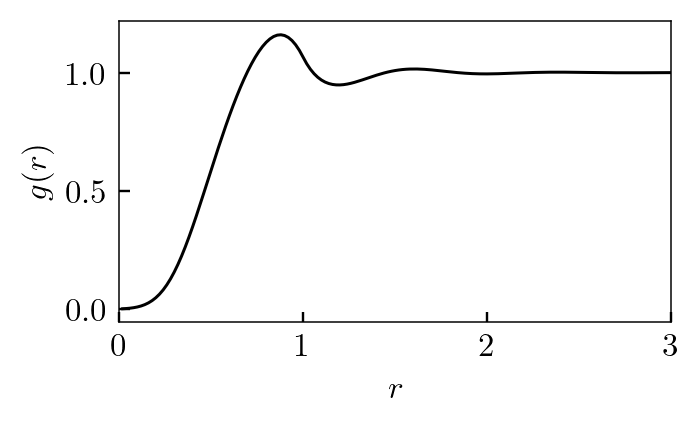

In [4]:
soln = solvent.solve(φ0, ρ0, monitor=verbose) # solve for the DPD potential
h00, c00, hq00 = soln.hr, soln.cr, soln.hq # extract for use in a moment

plt.plot(r, 1+h00)
plt.xlabel('$r$')
plt.ylabel('$g(r)$')
plt.xlim([0, 3])
plt.show()

Calculate thermodynamic quantities using the total correlation function $h(r)$.

For the integrals here, see Eqs. (2.5.20) and (2.5.22) in Hansen & McDonald, "Theory of Simple Liquids" (3rd edition): for the (excess) energy density,
$$
e \equiv \frac{U^\mathrm{ex}}{V} = 2\pi\rho^2 \int_0^\infty \mathrm{d}r \, r^2 \phi(r) g(r)
$$
and virial pressure,
$$
p = \rho + \frac{2\pi\rho^2}{3} \int_0^\infty \mathrm{d}r \, r^3 f(r) g(r)
$$
where $f(r) = −\mathrm{d}\phi/\mathrm{d}r$ is the force. Note that we have assumed $\beta = 1$ in our expressions, so energy is given in units of $k_\mathrm{B} T$. An integration by parts shows that the mean-field contributions, being these with g(r) = 1, are the same.

Here specifically the mean-field contributions are
$$
\frac{2\pi \rho^3}{3} \int_0^\infty \mathrm{d}r \, r^3 f(r) = A \int_0^1 \mathrm{d}r \, r^3 (1−r) = \frac{\pi A \rho^3}{30} \,.
$$

In [5]:
e_mf = p_mf = π*A00*ρ0**2/30

e_xc = 2*π*ρ0**2 * np.trapz(r**2*φ0*h00, dx=Δr)
e_ex = e_mf + e_xc
e = 3*ρ0/2 + e_ex

p_xc = 2*π*ρ0**2/3 * np.trapz(r**3*f0*h00, dx=Δr)
p_ex = p_mf + p_xc
p = ρ0 + p_ex

μ_ex = 4*π*ρ0 * np.trapz(r**2*(h00*(h00-c00)/2 - c00), dx=Δr)
μ = np.log(ρ0) + μ_ex

print(f'μ={μ:.4f} μ_ex={μ_ex:.4f} μ_id={μ-μ_ex:.4f}')

μ=13.2687 μ_ex=12.1701 μ_id=1.0986


# 2. Introduce solute

In [6]:
solute = SolutePicardHNC(ρ0, c00, grid)

pyHNC.solve: Picard iteration   0, error = 3.588e-16
pyHNC.solve: Picard converged


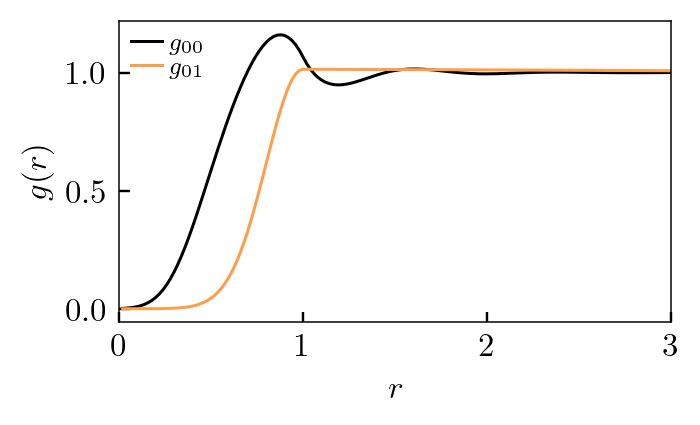

In [9]:
A01 = 25
φ01 = dpd_potential(A01, r)
soln = solute.solve(φ01, monitor=verbose)
h01, c01, hq01 = soln.hr, soln.cr, soln.hq

plt.plot(r, 1+h00, label=r'$g_{00}$')
plt.plot(r, 1+h01, label=r'$g_{01}$')
plt.legend(loc='best')
plt.xlabel('$r$')
plt.ylabel('$g(r)$')
plt.xlim([0, 3])
plt.show()